### [Regression: predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/basic_regression)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

1.12.0


#### Load and clean the dataset

In [3]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

In [4]:
dataset_path

'C:\\Users\\harshil\\.keras\\datasets\\auto-mpg.data'

In [5]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

In [6]:
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

#### Convert origin to one-hot

In [10]:
origin = dataset.pop('Origin')

In [11]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

In [12]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### Split the dataset

In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### Inspect the data

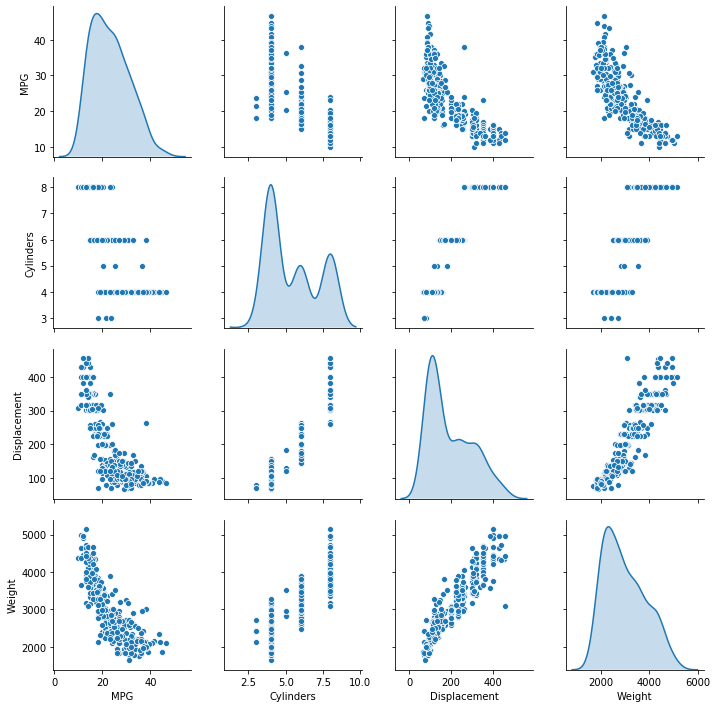

In [14]:
sb.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()

In [15]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Split features from labels

In [16]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### Normalization

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [18]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [19]:
normed_train_data.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,-1.286751,2.143005,-0.495225


#### Build the model

In [20]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',
                 optimizer=optimizer,
                 metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model

In [21]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [22]:
class PrintProg(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0:
            print(epoch, end=' ')

In [23]:
EPOCHS = 1000

In [24]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintProg()])

0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 

#### Inspect and plot `history`

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,8.526928,2.192845,8.526928,2.847493,1.074287,2.847493,995
996,8.755720,2.172517,8.755720,2.874712,1.092593,2.874712,996
997,8.092577,2.078235,8.092577,2.729049,1.038782,2.729049,997
998,8.510132,2.135333,8.510132,3.039358,1.180792,3.039358,998
999,8.210120,2.137827,8.210120,2.940161,1.073151,2.940161,999


In [26]:
def plot():
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(15, 6))

    plt.subplot(1,2,1)
    plt.grid(False)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Abs Error')
    plt.ylim([0,5])
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Training MAE')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Validation MAE')
    plt.legend()

    plt.subplot(1,2,2)
    plt.grid(False)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.ylim([0,20])
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Training MSE')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Validation MSE')
    plt.legend()
    
    plt.show()

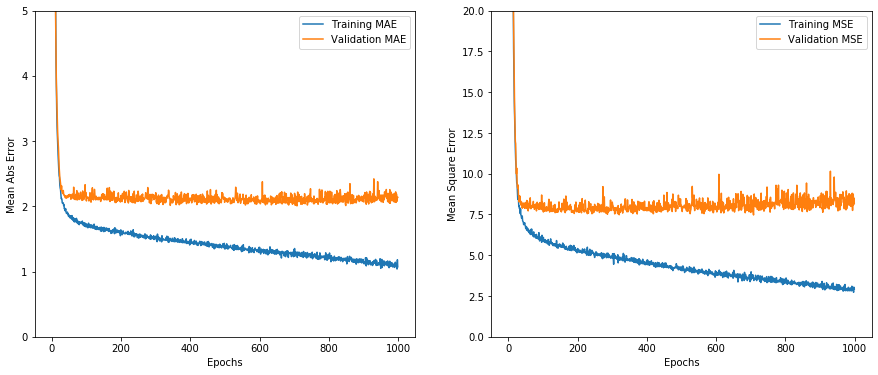

In [27]:
plot()

#### Early Stopping

In [28]:
model = build_model()

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [30]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintProg()])

0 50 

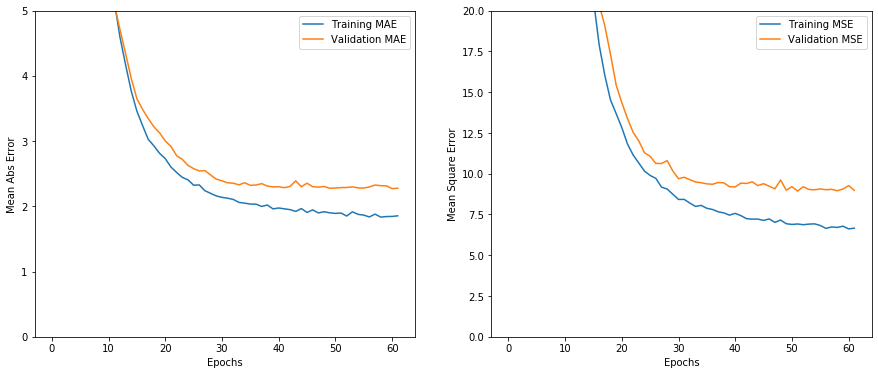

In [31]:
plot()

#### Prediction

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

In [33]:
print('Test set evaluation:\n MAE: {:.5f} MPG\n MSE: {:.5f} MPG'.format(mae, mse))

Test set evaluation:
 MAE: 1.93886 MPG
 MSE: 6.22608 MPG


In [34]:
test_predictions = model.predict(normed_test_data).flatten()

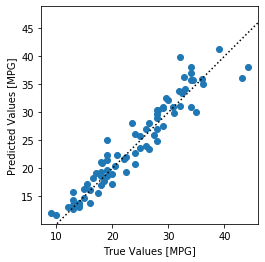

In [35]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predicted Values [MPG]')
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 100], [-100, 100], 'k:')
plt.show()

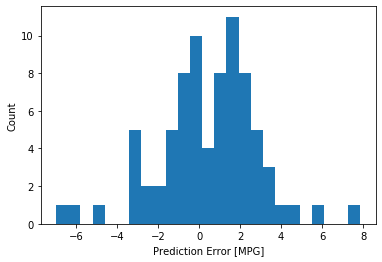

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')
plt.show()